In [6]:
import string
from collections import Counter

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
df = pd.read_csv('unsc.csv')

In [8]:
df.full_date.sort_values()

0        1995-01-06
29       1995-01-12
30       1995-01-12
31       1995-01-12
32       1995-01-12
            ...    
78639    2020-12-22
78681    2020-12-22
78643    2020-12-22
78673    2020-12-29
78672    2020-12-29
Name: full_date, Length: 82200, dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82200 entries, 0 to 82199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   country           82200 non-null  object
 1   full_date         82200 non-null  object
 2   speech            82200 non-null  object
 3   speech_tokenized  82200 non-null  object
 4   topic             82200 non-null  object
dtypes: object(5)
memory usage: 3.1+ MB


In [10]:
df.head(2)

,country,full_date,speech,speech_tokenized,topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...


# Pre processing text

In [11]:
stop_words = set(stopwords.words('english'))

additional_stop_words = ['also', 'would', 'must', 'like', 'need', 'continue', 'take', 'country', 
                        'you', 'make', 'mr', 'including', 'member', 'committee', 'situation',
                        'united', 'nation', 'item', 'invite', 'speaker', 'representative', 'accordance', 
                        'thank', 'vote', 'meeting', 'president', 'floor', 'participate', 
                        'consideration', 'region', 'state', 'international']  

lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess_text(text):

    # Remoção de stopwords e pontuações
    preprocessed_text = text.lower()
    preprocessed_text = ''.join([char for char in preprocessed_text if char not in string.punctuation])
    preprocessed_text = ' '.join([word for word in preprocessed_text.split() if word not in stop_words and word.isalpha()])
    preprocessed_text = ' '.join([word for word in preprocessed_text.split() if word not in additional_stop_words and word.isalpha()])

    # Lematização
    preprocessed_text = ' '.join([lemmatizer.lemmatize(word) for word in preprocessed_text.split()])

    return preprocessed_text


df['processed_speech'] = df['speech'].apply(preprocess_text)

In [13]:
df['processed_speech'] = df['processed_speech'].str.replace('I now give the floor to', '')
df['processed_speech'] = df['processed_speech'].str.replace('I thank the representative of', '')

In [14]:
def gather_most_frequent_words(data, column, top_n):

    text = ' '.join(data[column])
    words = text.split()
    word_counts = Counter(words)
    most_frequent_words = word_counts.most_common(top_n)

    return most_frequent_words

In [15]:
most_frequent_words = gather_most_frequent_words(df, 'processed_speech', top_n=100)
most_frequent_words

[('council', 305518),
 ('security', 269603),
 ('nation', 187834),
 ('peace', 167557),
 ('conflict', 125591),
 ('resolution', 124821),
 ('support', 120205),
 ('effort', 113444),
 ('government', 100122),
 ('state', 98449),
 ('people', 93311),
 ('community', 86445),
 ('political', 85200),
 ('process', 82413),
 ('humanitarian', 78828),
 ('work', 77001),
 ('country', 72371),
 ('right', 72340),
 ('report', 71237),
 ('development', 70045),
 ('important', 66955),
 ('mission', 65259),
 ('woman', 65205),
 ('issue', 63775),
 ('national', 62027),
 ('law', 60725),
 ('party', 60134),
 ('civilian', 59646),
 ('force', 59036),
 ('secretarygeneral', 58566),
 ('year', 58255),
 ('organization', 57407),
 ('african', 56537),
 ('group', 55440),
 ('cooperation', 55359),
 ('today', 54818),
 ('human', 53595),
 ('republic', 53321),
 ('action', 53201),
 ('member', 53155),
 ('welcome', 52305),
 ('violence', 52132),
 ('child', 51773),
 ('one', 50834),
 ('well', 50246),
 ('regard', 50216),
 ('made', 49489),
 ('new',

# Training model

In [16]:
import warnings
# Suprimindo o aviso de depreciação
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

def train_dynamic_topic_model(data, num_topics, max_iter):
    # Inicialização do vetorizador para transformar os textos em uma matriz de contagem de palavras
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(data['processed_speech'])
    
    # Treinamento do modelo de LDA
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=max_iter)
    lda_model.fit(X)
    
    # Extração das palavras-chave para cada tópico identificado
    feature_names = vectorizer.get_feature_names_out()
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # Obtém as palavras mais importantes para cada tópico
        topic_keywords[topic_idx] = [feature_names[i] for i in topic.argsort()[-10:]]
    
    # Atribuição de tópicos ao DataFrame
    topics_assigned = []
    lda_topics = []  # New list to store topic IDs
    for text in data['processed_speech']:
        topics = lda_model.transform(vectorizer.transform([text]))[0]
        dominant_topic = topics.argmax()
        topics_assigned.append(topic_keywords[dominant_topic])
        lda_topics.append(f"topic_{dominant_topic}")  # Create topic ID
        
    # Adiciona os tópicos atribuídos como novas colunas no DataFrame
    data['assigned_topics'] = topics_assigned
    data['lda_topic'] = lda_topics  # Add new column with topic IDs
    
    return lda_model, topic_keywords


dynamic_lda, dynamic_topic_keywords = train_dynamic_topic_model(df, num_topics=5, max_iter=100)
df.head(2)

,country,full_date,speech,speech_tokenized,topic,processed_speech,assigned_topics,lda_topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina,first security council held year welcome new m...,"[state, republic, agenda, statement, rule, dra...",topic_0
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...,outset apologize everyone delay starting ackno...,"[state, republic, agenda, statement, rule, dra...",topic_0


In [21]:
df.assigned_topics.value_counts()

assigned_topics
[state, republic, agenda, statement, rule, draft, member, resolution, security, council]             25869
[state, country, development, african, effort, council, support, peace, nation, security]            22030
[process, israeli, people, east, israel, kosovo, council, security, peace, palestinian]              12417
[civilian, syria, party, iraq, council, political, afghanistan, government, people, humanitarian]    11990
[violence, civilian, right, nation, armed, security, child, council, woman, conflict]                 9894
Name: count, dtype: int64

In [22]:
df.to_csv('UNSC_Final.csv', index=False)

In [29]:
df.head(-2)

,country,full_date,speech,speech_tokenized,topic,processed_speech,assigned_topics,lda_topic
0,Argentina,1995-01-06,As this is the first meeting of the Security C...,"['As', 'this', 'is', 'the', 'first', 'meeting'...",Bosnia and Herzegovina,first security council held year welcome new m...,"[state, republic, agenda, statement, rule, dra...",topic_0
1,Argentina,1995-01-12,I should like at the outset of the meeting to ...,"['I', 'should', 'like', 'at', 'the', 'outset',...",Federal Republic of Yugoslavia (Serbia and Mon...,outset apologize everyone delay starting ackno...,"[state, republic, agenda, statement, rule, dra...",topic_0
2,Bosnia And Herzegovina,1995-01-12,"First, Mr. President, let me welcome you to yo...","['First', ',', 'Mr.', 'President', ',', 'let',...",Federal Republic of Yugoslavia (Serbia and Mon...,first let welcome new position extend warmest ...,"[process, israeli, people, east, israel, kosov...",topic_3
3,Argentina,1995-01-12,The next speaker is the representative of Croa...,"['The', 'next', 'speaker', 'is', 'the', 'repre...",Federal Republic of Yugoslavia (Serbia and Mon...,next croatia call,"[state, republic, agenda, statement, rule, dra...",topic_0
4,Croatia,1995-01-12,"Allow me, Sir, to congratulate you on your ass...","['Allow', 'me', ',', 'Sir', ',', 'to', 'congra...",Federal Republic of Yugoslavia (Serbia and Mon...,allow sir congratulate assumption presidency s...,"[process, israeli, people, east, israel, kosov...",topic_3
...,...,...,...,...,...,...,...,...
82193,Russian Federation,2020-12-07,We would like to thank the Special Representat...,"['We', 'would', 'like', 'to', 'thank', 'the', ...",The situation concerning the Democratic Republ...,special secretarygeneral head nation organizat...,"[state, country, development, african, effort,...",topic_2
82194,United Kingdom Of Great Britain And Northern I...,2020-12-07,Let me begin by thanking Special Representativ...,"['Let', 'me', 'begin', 'by', 'thanking', 'Spec...",The situation concerning the Democratic Republ...,let begin thanking special secretary general l...,"[state, country, development, african, effort,...",topic_2
82195,China,2020-12-07,I thank Special Representative of the Secretar...,"['I', 'thank', 'Special', 'Representative', 'o...",The situation concerning the Democratic Republ...,special secretarygeneral zerrougui briefing de...,"[state, country, development, african, effort,...",topic_2
82196,Estonia,2020-12-07,"I wish to thank you, Mr. President, for having...","['I', 'wish', 'to', 'thank', 'you', ',', 'Mr.'...",The situation concerning the Democratic Republ...,wish convened today special zerrougui valuable...,"[state, country, development, african, effort,...",topic_2


# Results

## Topics Frequency

In [85]:
df['year'] = pd.to_datetime(df['full_date']).dt.year
yearly_pivot = df.groupby(by=['year', 'lda_topic']).size().unstack(fill_value=0)
yearly_pivot = yearly_pivot.rename(
    columns = {
        'topic_0': 'n°0 - Processos', 
        'topic_1': 'n°1 - Conflitos', 
        'topic_2': 'n°2 - Desenvolvimento', 
        'topic_3': 'n°3 - Conflitos', 
        'topic_4': 'n°4 - Direitos Humanos'
    }
)
yearly_pivot = yearly_pivot.div(yearly_pivot.sum(axis=1), axis=0) * 100
yearly_pivot.head(5)

lda_topic,n°0 - Processos,n°1 - Conflitos,n°2 - Desenvolvimento,n°3 - Conflitos,n°4 - Direitos Humanos
year,,,,,
1995,38.719068,5.749636,19.650655,34.206696,1.673945
1996,38.307030,12.912482,16.355811,30.487805,1.936872
1997,38.225630,9.200438,17.743702,31.106243,3.723987
1998,36.647009,13.142376,20.808762,20.050548,9.351306
1999,40.855549,10.725356,22.504650,14.445133,11.469312


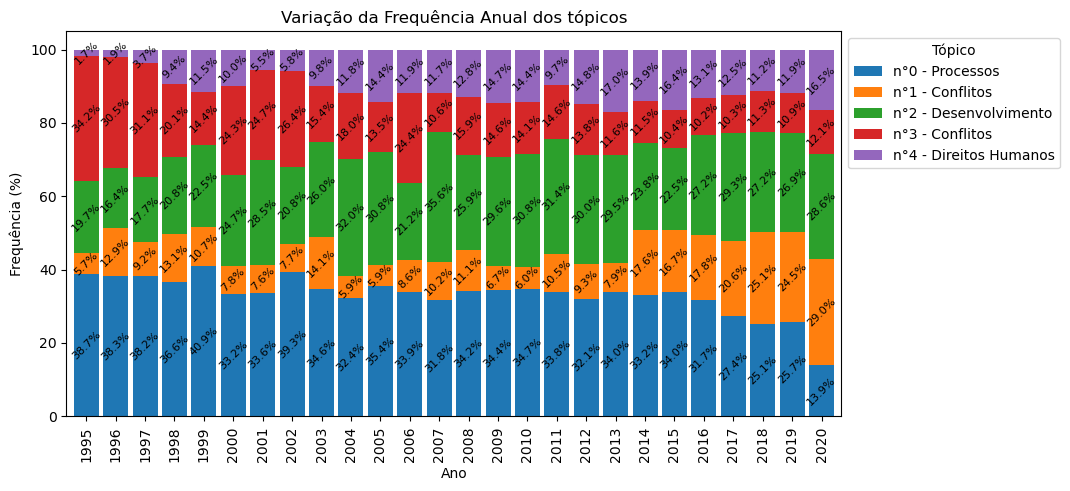

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))
yearly_pivot.plot(kind='bar', stacked=True, ax=ax, width=0.85)

plt.title(f'Variação da Frequência Anual dos tópicos')
plt.xlabel('Ano')
plt.ylabel('Frequência (%)')
plt.legend(title='Tópico', bbox_to_anchor=(1.0, 1), loc='best')
plt.grid(False)

# Adicionando os percentuais no meio de cada barra com a fonte cinza escuro e inclinada em 30°
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h:.1f}%' for h in container.datavalues], 
                 label_type='center', color='black', fontsize=8, rotation=45)

plt.savefig(f'charts/topic_frequency/topics_yearly', bbox_inches='tight')
plt.show()


## Keywords frequency

In [142]:
import matplotlib.pyplot as plt
import pandas as pd

def get_keywords_freq(lda_topic, df):
    
    df_lda_topic = df[df['lda_topic'] == lda_topic]
    iterator = int(lda_topic.replace('topic_', ''))

    keywords = dynamic_topic_keywords[iterator]
    
    for word in keywords:
        df_lda_topic[word + '_freq'] = df_lda_topic['processed_speech'].str.count(word)

    df_lda_topic['full_date'] = pd.to_datetime(df_lda_topic['full_date'])
    df_lda_topic['year'] = df_lda_topic['full_date'].dt.year
    yearly_frequency = df_lda_topic.groupby(by='year')[[word + '_freq' for word in keywords]].sum()

    # Normalizando os dados para 100% empilhado
    yearly_frequency = yearly_frequency.div(yearly_frequency.sum(axis=1), axis=0) * 100

    # Arrumando nome da coluna
    yearly_frequency.columns = [column.replace('_freq', '') for column in yearly_frequency.columns]
    
    fig, ax = plt.subplots(figsize=(10, 5))

    mapping = {
    'topic_0': 'n°0 - Processos',
    'topic_1': 'n°1 - Conflitos',
    'topic_2': 'n°2 - Desenvolvimento',
    'topic_3': 'n°3 - Conflitos',
    'topic_4': 'n°4 - Direitos Humanos'
    }

    topic_treated = mapping.get(lda_topic, lda_topic)

    # Criando o gráfico de barras 100% empilhado
    yearly_frequency.plot(kind='bar', stacked=True, ax=ax, width=0.85)

    plt.title(f'{topic_treated}', fontsize=12)
    fig.suptitle('Participação Anual (%) das Palavras-Chave', fontsize=15)
    plt.xlabel('Ano')
    plt.ylabel('Frequência (%)')
    plt.legend(title='Palavra-Chave', bbox_to_anchor=(1.05, 1), loc='best')
    plt.grid(False)

    # Adicionando os percentuais no meio de cada barra com a fonte preta e inclinada em 45°
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{h:.1f}%' for h in container.datavalues], 
                     label_type='center', color='black', fontsize=8, rotation=45, fontweight='bold')

    plt.savefig(f'charts/keyword_frequency/topic_{iterator}', bbox_inches='tight')

for topic in df['lda_topic'].sort_values().unique():
    get_keywords_freq(lda_topic=topic, df=df)

C:\Users\anton\AppData\Local\Temp\ipykernel_27852\1108686609.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lda_topic[word + '_freq'] = df_lda_topic['processed_speech'].str.count(word)
C:\Users\anton\AppData\Local\Temp\ipykernel_27852\1108686609.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lda_topic[word + '_freq'] = df_lda_topic['processed_speech'].str.count(word)
C:\Users\anton\AppData\Local\Temp\ipykernel_27852\1108686609.py:12: SettingWithCopyWarning: 
A value is trying to be set on 